In [1]:
CORPUS_DIR = "longreddit_construction/long-reddit-corpus-liwc"
# CORPUS_DIR = "reddit-corpus-small"
# CORPUS_DIR =
DATA_DIR = "data_liwc"
PLOT_DIR = "html/graphs_liwc"
# hyperconv_range = range(0, 9+1)
# hyperconv_range = range(3, 20+1)
rank_range = range(9, 9+1)
max_rank = max(rank_range)
anomaly_threshold = 1.5
WINDOW_SIZE = 10

In [2]:
import os
os.chdir('../..')
import convokit

In [3]:
os.chdir('convokit/tensors')

In [4]:
from convokit import Corpus
import pickle
import numpy as np
import os
from tensorly.decomposition import parafac
from convokit.tensors.utils import plot_factors
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

In [46]:
def get_anomalous_points(factor_full, idx, anomaly_threshold=1.5):
    scaler = StandardScaler()
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > anomaly_threshold).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -anomaly_threshold).flatten()
    return pos_pts, neg_pts

In [63]:
def generate_high_level_summary():
    # generate_plots()
    with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
        rank_to_factors = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'liwc_features.p'), 'rb') as f:
        liwc_features = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
        subreddits = pickle.load(f)

    time_factor = rank_to_factors[max_rank][0] # (9, 9)
    thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
    feature_factor = rank_to_factors[max_rank][2] # (140, 9)
    idx_to_distinctive_threads = defaultdict(dict)
    idx_to_distinctive_features = defaultdict(dict)

    # normalizing
    subreddit_totals = Counter(subreddits)
    for idx in range(max_rank):
        pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx, anomaly_threshold=3)
        idx_to_distinctive_threads[idx]['pos_threads'] = pos_thread_pts
        idx_to_distinctive_threads[idx]['neg_threads'] = neg_thread_pts

        pos_features, neg_features = get_anomalous_points(feature_factor, idx)
        idx_to_distinctive_features[idx]['pos_features'] = pos_features
        idx_to_distinctive_features[idx]['neg_features'] = neg_features

    return idx_to_distinctive_threads, idx_to_distinctive_features 


In [64]:
idx_to_distinctive_threads, idx_to_distinctive_features = generate_high_level_summary()

In [66]:
for factor_idx, threads in idx_to_distinctive_threads.items():
    print("Factor {}".format(factor_idx+1))
    print("Number of pos threads: {}".format(len(threads['pos_threads'])))
    print("Number of neg threads: {}".format(len(threads['neg_threads'])))
#     print(threads['neg_threads'])
    print("Positive feats: {}".format(idx_to_distinctive_features[factor_idx]['pos_features']))
    print("Negative feats: {}".format(idx_to_distinctive_features[factor_idx]['neg_features']))
    print()

Factor 1
Number of pos threads: 196
Number of neg threads: 181
Positive feats: [0 1 2 3 4 7 8]
Negative feats: []

Factor 2
Number of pos threads: 0
Number of neg threads: 448
Positive feats: [0]
Negative feats: []

Factor 3
Number of pos threads: 18
Number of neg threads: 265
Positive feats: [3 7 8]
Negative feats: [ 1  2 81 92]

Factor 4
Number of pos threads: 105
Number of neg threads: 49
Positive feats: [ 2  7  8 35]
Negative feats: [ 1  3  4 81 92]

Factor 5
Number of pos threads: 225
Number of neg threads: 36
Positive feats: [ 3 81 92]
Negative feats: [1 4]

Factor 6
Number of pos threads: 147
Number of neg threads: 11
Positive feats: [1 3]
Negative feats: [ 4 81]

Factor 7
Number of pos threads: 34
Number of neg threads: 104
Positive feats: [0 2 3]
Negative feats: [8]

Factor 8
Number of pos threads: 112
Number of neg threads: 302
Positive feats: [ 5  8 40 92]
Negative feats: [ 7 29 30 75 82 87]

Factor 9
Number of pos threads: 325
Number of neg threads: 171
Positive feats: [0]


## Verify that the trends match for a random factor

Let's load the tensor

In [9]:
with open(os.path.join(DATA_DIR, 'tensor.p'), 'rb') as f:
    tensor = pickle.load(f)

In [10]:
import matplotlib.pyplot as plt

In [11]:
tensor.shape # (window, thread_no, liwc_feat)

(11, 29487, 93)

In [12]:
threads = idx_to_distinctive_threads[0]['pos_threads']

In [13]:
feats = idx_to_distinctive_features[0]['pos_features']

In [14]:
idx_to_distinctive_features.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
feats

array([0, 1, 2, 3, 4, 7, 8])

In [16]:
len(threads)

1530

In [17]:
tensor[:, threads][:, :, feats]

array([[[114.  , 515.06, 707.09, ..., 315.15, 754.58, 527.97],
        [113.  , 397.66, 578.9 , ..., 379.98, 721.55, 395.17],
        [ 54.  , 497.7 , 309.49, ..., 306.16, 682.78, 493.89],
        ...,
        [ 90.  , 436.52, 666.1 , ..., 281.39, 638.71, 490.4 ],
        [245.  , 604.89, 596.31, ..., 382.78, 634.52, 414.1 ],
        [130.  , 763.85, 628.71, ..., 758.51, 613.81, 331.9 ]],

       [[ 93.  , 495.58, 625.64, ..., 330.93, 744.26, 533.13],
        [131.  , 369.76, 498.09, ..., 379.98, 723.84, 414.03],
        [ 49.  , 423.72, 358.11, ..., 379.39, 738.34, 496.67],
        ...,
        [ 83.  , 444.21, 569.41, ..., 306.16, 578.71, 455.4 ],
        [231.  , 580.05, 535.87, ..., 309.04, 629.48, 422.88],
        [130.  , 763.85, 628.71, ..., 758.51, 613.81, 331.9 ]],

       [[ 91.  , 495.58, 625.64, ..., 330.93, 723.43, 520.63],
        [123.  , 419.06, 470.17, ..., 306.75, 623.84, 352.49],
        [ 48.  , 403.94, 309.11, ..., 354.62, 763.34, 455.  ],
        ...,
        [ 86

In [36]:
def plot_trend(factor_idx):
    plt.figure(dpi=200, figsize=(9, 6))
    pos_threads = idx_to_distinctive_threads[factor_idx]['pos_threads']
    neg_threads = idx_to_distinctive_threads[factor_idx]['neg_threads']

    pos_feats = idx_to_distinctive_features[factor_idx]['pos_features']
    neg_feats = idx_to_distinctive_features[factor_idx]['neg_features']
    
    pos_pos = tensor[:, pos_threads][:, :, pos_feats].sum(axis=1)
    pos_neg = tensor[:, pos_threads][:, :, neg_feats].sum(axis=1)
    neg_neg = tensor[:, neg_threads][:, :, neg_feats].sum(axis=1)
    neg_pos = tensor[:, neg_threads][:, :, pos_feats].sum(axis=1)
            
    fig, axs = plt.subplots(2, 2)
    
    sign_to_tensor_subset = {
        ('pos', 'pos'): pos_pos,
        ('pos', 'neg'): pos_neg,
        ('neg', 'neg'): neg_neg,
        ('neg', 'pos'): neg_pos
    }
    
    for idx, ((sign1, sign2), tensor_) in enumerate(sign_to_tensor_subset.items()):
        try:
            axs[idx//2][idx % 2].plot(tensor_)
            axs[idx//2][idx % 2].set_title("{} thrds, {} feats, factor {}".format(sign1, sign2, factor_idx+1))
        except ZeroDivisionError:
            pass
    
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

<Figure size 1800x1200 with 0 Axes>

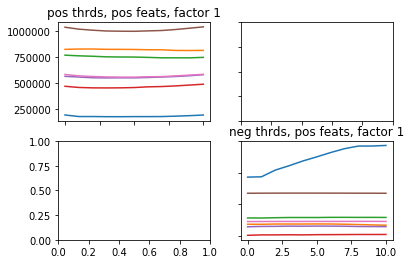

<Figure size 1800x1200 with 0 Axes>

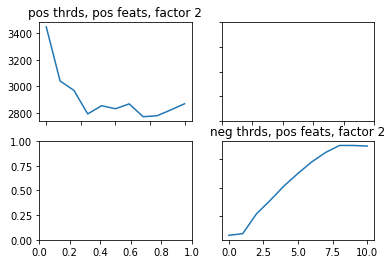

<Figure size 1800x1200 with 0 Axes>

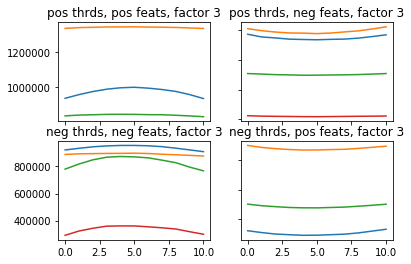

<Figure size 1800x1200 with 0 Axes>

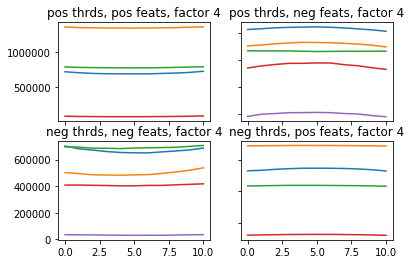

<Figure size 1800x1200 with 0 Axes>

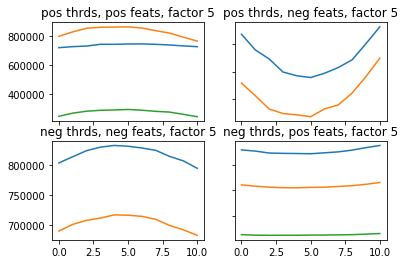

<Figure size 1800x1200 with 0 Axes>

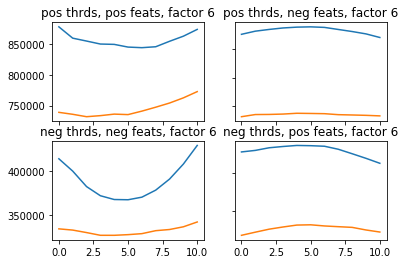

<Figure size 1800x1200 with 0 Axes>

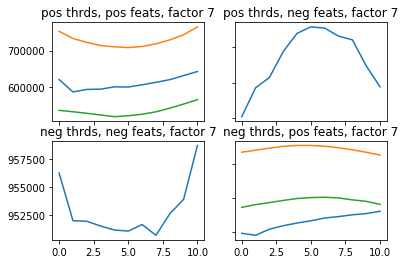

<Figure size 1800x1200 with 0 Axes>

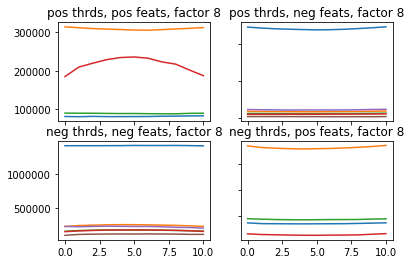

<Figure size 1800x1200 with 0 Axes>

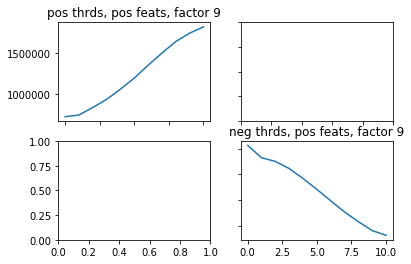

In [37]:
for i in range(max_rank):
    plot_trend(i)

## Factor stats

In [38]:
with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
    rank_to_factors = pickle.load(f)

with open(os.path.join(DATA_DIR, 'liwc_features.p'), 'rb') as f:
    liwc_features = pickle.load(f)

with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
    subreddits = pickle.load(f)

time_factor = rank_to_factors[max_rank][0] # (9, 9)
thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
feature_factor = rank_to_factors[max_rank][2] # (140, 9)

def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]

In [26]:
from numpy.linalg import norm
d = dict()
rank = 9
for i in range(9):
    d[i] = dict()
    t = rank_one_tensor(*(time_factor[:, i], thread_factor[:, i], feature_factor[:, i]))
    d[i]['norm'] = norm(t)

In [33]:
for i in range(9):
    d[i]['time_range'] = abs(max(time_factor[:, i]) - min(time_factor[:, i]))
    d[i]['thread_range'] = abs(max(thread_factor[:, i]) - min(thread_factor[:, i]))
    d[i]['feat_range'] = abs(max(feature_factor[:, i]) - min(feature_factor[:, i]))
    d[i]['range_product'] = d[i]['time_range'] * d[i]['thread_range'] * d[i]['feat_range']
    #     print(range_time * range_thread * range_feat)

In [34]:
import pandas as pd
df = pd.DataFrame(d).T
df.index = range(1, 10)

In [35]:
df

,feat_max,feat_range,max_product,norm,range_product,thread_max,thread_range,time_max,time_range
1,0.550391,0.550139,258.255640,862721.812500,5.157129,0.001811,0.011028,259073.405755,850.032988
2,0.975421,1.107726,787.163347,184178.328125,1103.082295,0.016432,0.177960,49111.690957,5595.687873
3,0.551287,1.035905,414.216293,92415.710938,591.390105,0.025226,0.100498,29785.370311,5680.615793
4,0.516293,0.964524,573.964516,85310.414062,297.339059,0.048951,0.073195,22710.384037,4211.672588
5,0.581606,1.109390,1238.994375,76707.164062,725.834229,0.087127,0.127250,24450.521202,5141.580627
6,0.379568,1.194307,311.655473,74910.328125,400.489016,0.042640,0.069619,19255.997758,4816.645385
7,0.727508,0.889234,248.904309,50361.839844,218.468509,0.396631,0.966574,862.597705,254.177642
8,0.416909,0.792307,354.238693,35851.832031,402.659521,0.928341,2.866933,915.265379,177.266611
9,1.338217,1.444313,2440.168826,68404.906250,12362.014401,3.998141,6.285784,456.073875,1361.659288


## Individual thread contributions to trajectories

In [39]:
liwc_features[-1]

'OtherP'

In [57]:
def plot_trend_specific(factor_idx):
    plt.figure(dpi=200, figsize=(9, 6))
    pos_threads = idx_to_distinctive_threads[factor_idx]['pos_threads']
    neg_threads = idx_to_distinctive_threads[factor_idx]['neg_threads']
    print(neg_threads)

    pos_feats = idx_to_distinctive_features[factor_idx]['pos_features']
    neg_feats = idx_to_distinctive_features[factor_idx]['neg_features']
    
    pos_pos = tensor[:, pos_threads][:, :, pos_feats].sum(axis=1)
    pos_neg = tensor[:, pos_threads][:, :, neg_feats].sum(axis=1)
    neg_neg = tensor[:, neg_threads][:, :, neg_feats].sum(axis=1)
    neg_pos = tensor[:, neg_threads][:, :, pos_feats].sum(axis=1)
            
    fig, axs = plt.subplots(2, 2)
    
    sign_to_tensor_subset = {
        ('pos', 'pos'): pos_pos,
        ('pos', 'neg'): pos_neg,
        ('neg', 'neg'): neg_neg,
        ('neg', 'pos'): neg_pos
    }
    
    for idx, ((sign1, sign2), tensor_) in enumerate(sign_to_tensor_subset.items()):
        try:
            axs[idx//2][idx % 2].plot(tensor_)
            axs[idx//2][idx % 2].set_title("{} thrds, {} feats, factor {}".format(sign1, sign2, factor_idx+1))
        except ZeroDivisionError:
            pass
    
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

[ 6642 16180 16317 18486 23675]


<Figure size 1800x1200 with 0 Axes>

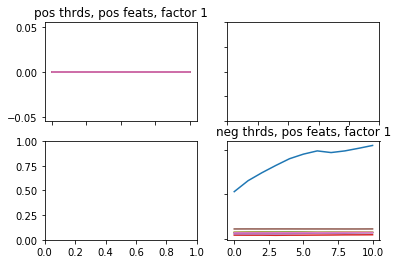

In [58]:
plot_trend_specific(0) # anomaly_threshold = 9

In [61]:
def plot_trend_all(factor_idx):
    plt.figure(dpi=200, figsize=(9, 6))
    pos_feats = idx_to_distinctive_features[factor_idx]['pos_features']
    neg_feats = idx_to_distinctive_features[factor_idx]['neg_features']
    
    pos_pos = tensor[:, :, pos_feats].sum(axis=1)
    pos_neg = tensor[:, :, neg_feats].sum(axis=1)
    neg_neg = tensor[:, :, neg_feats].sum(axis=1)
    neg_pos = tensor[:, :, pos_feats].sum(axis=1)
            
    fig, axs = plt.subplots(2, 2)
    
    sign_to_tensor_subset = {
        ('pos', 'pos'): pos_pos,
        ('pos', 'neg'): pos_neg,
        ('neg', 'neg'): neg_neg,
        ('neg', 'pos'): neg_pos
    }
    
    for idx, ((sign1, sign2), tensor_) in enumerate(sign_to_tensor_subset.items()):
        try:
            axs[idx//2][idx % 2].plot(tensor_)
            axs[idx//2][idx % 2].set_title("{} thrds, {} feats, factor {}".format(sign1, sign2, factor_idx+1))
        except ZeroDivisionError:
            pass
    
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

<Figure size 1800x1200 with 0 Axes>

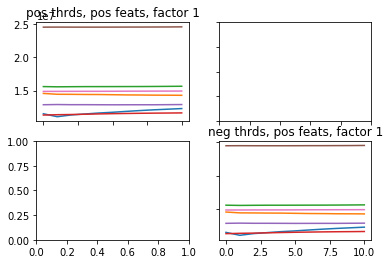

In [62]:
plot_trend_all(0)

[  405   838  1042  1100  1506  1530  1652  1967  2707  2830  3251  3495
  3592  4617  5222  5356  5830  5980  6642  6927  7874  9092  9161 10151
 10430 10482 11428 11483 11747 12710 12756 13406 13843 14181 14213 14382
 14564 14755 14793 14873 14876 14913 14966 14993 15057 15073 15097 15623
 15649 16121 16180 16202 16261 16317 16366 16435 16437 16516 16538 16546
 16670 16848 16975 17050 17058 17096 17105 17177 17683 18381 18398 18403
 18408 18422 18449 18464 18480 18486 18500 18609 18610 18625 18632 20534
 20727 21294 22317 22319 22325 22326 22334 22340 22349 22396 22419 22438
 22497 22503 22536 22549 22576 22600 22655 22673 23018 23036 23042 23308
 23335 23398 23399 23427 23470 23489 23493 23525 23552 23577 23599 23658
 23675 23681 23707 23733 23752 23765 23778 23850 23885 23994 24163 24212
 24288 24341 24632 24947 25708 26342 26357 26509 26542 26552 26562 26564
 26568 26569 26572 26587 26589 26590 26602 26662 26668 26669 26682 26693
 26694 26725 26737 26744 26759 26778 26792 26819 26

<Figure size 1800x1200 with 0 Axes>

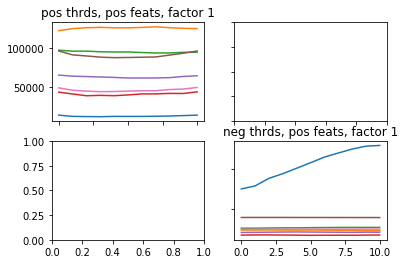

In [67]:
plot_trend_specific(0) # anomaly_threshold = 3